In [2]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

In [3]:
from sparkocr import start
from pyspark import SparkConf
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = ""

conf = SparkConf()\
.set("spark.kryoserializer.buffer.max", "2047")\
.set("spark.executor.memory", "32g")\
.set("spark.driver.memory","32g")

spark = start(jar_path=spark_ocr_jar_path, extra_conf=conf)

spark

Spark version: 3.5.0
Spark NLP version: 6.1.3
Spark NLP for Healthcare version: 6.1.1
Spark OCR version: 6.1.1



25/10/20 17:56:01 WARN Utils: Your hostname, jose-LOQ-15ARP9 resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface wlo1)
25/10/20 17:56:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/jose/spark-ocr/sparkocr/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jose/.ivy2/cache
The jars for the packages stored in: /home/jose/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8935daf5-b977-4e8f-bc7f-b2f24f3ee69d;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.1.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	f

# Image input file

In [5]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_pdf
from pyspark.ml import PipelineModel

In [4]:
imagePath = "./data/images/pubmed/*.jpg"

df = spark.read.format("binaryFile").load(imagePath)

bin_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

df = bin_to_image.transform(df).cache().limit(2)
df.show()

+--------------------+---------+--------------------+--------------------+-------+-------+
|               image|exception|                path|    modificationTime| length|pagenum|
+--------------------+---------+--------------------+--------------------+-------+-------+
|{file:/home/jose/...|     NULL|file:/home/jose/s...|2025-09-19 11:22:...|1438004|      0|
|{file:/home/jose/...|     NULL|file:/home/jose/s...|2025-09-19 11:22:...|1043573|      0|
+--------------------+---------+--------------------+--------------------+-------+-------+




    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/images/pubmed/main_1__4.jpg
    Resolution: 150 dpi
    Width: 1241 px
    Height: 1654 px
    Mode: 5
    Number of channels: 3


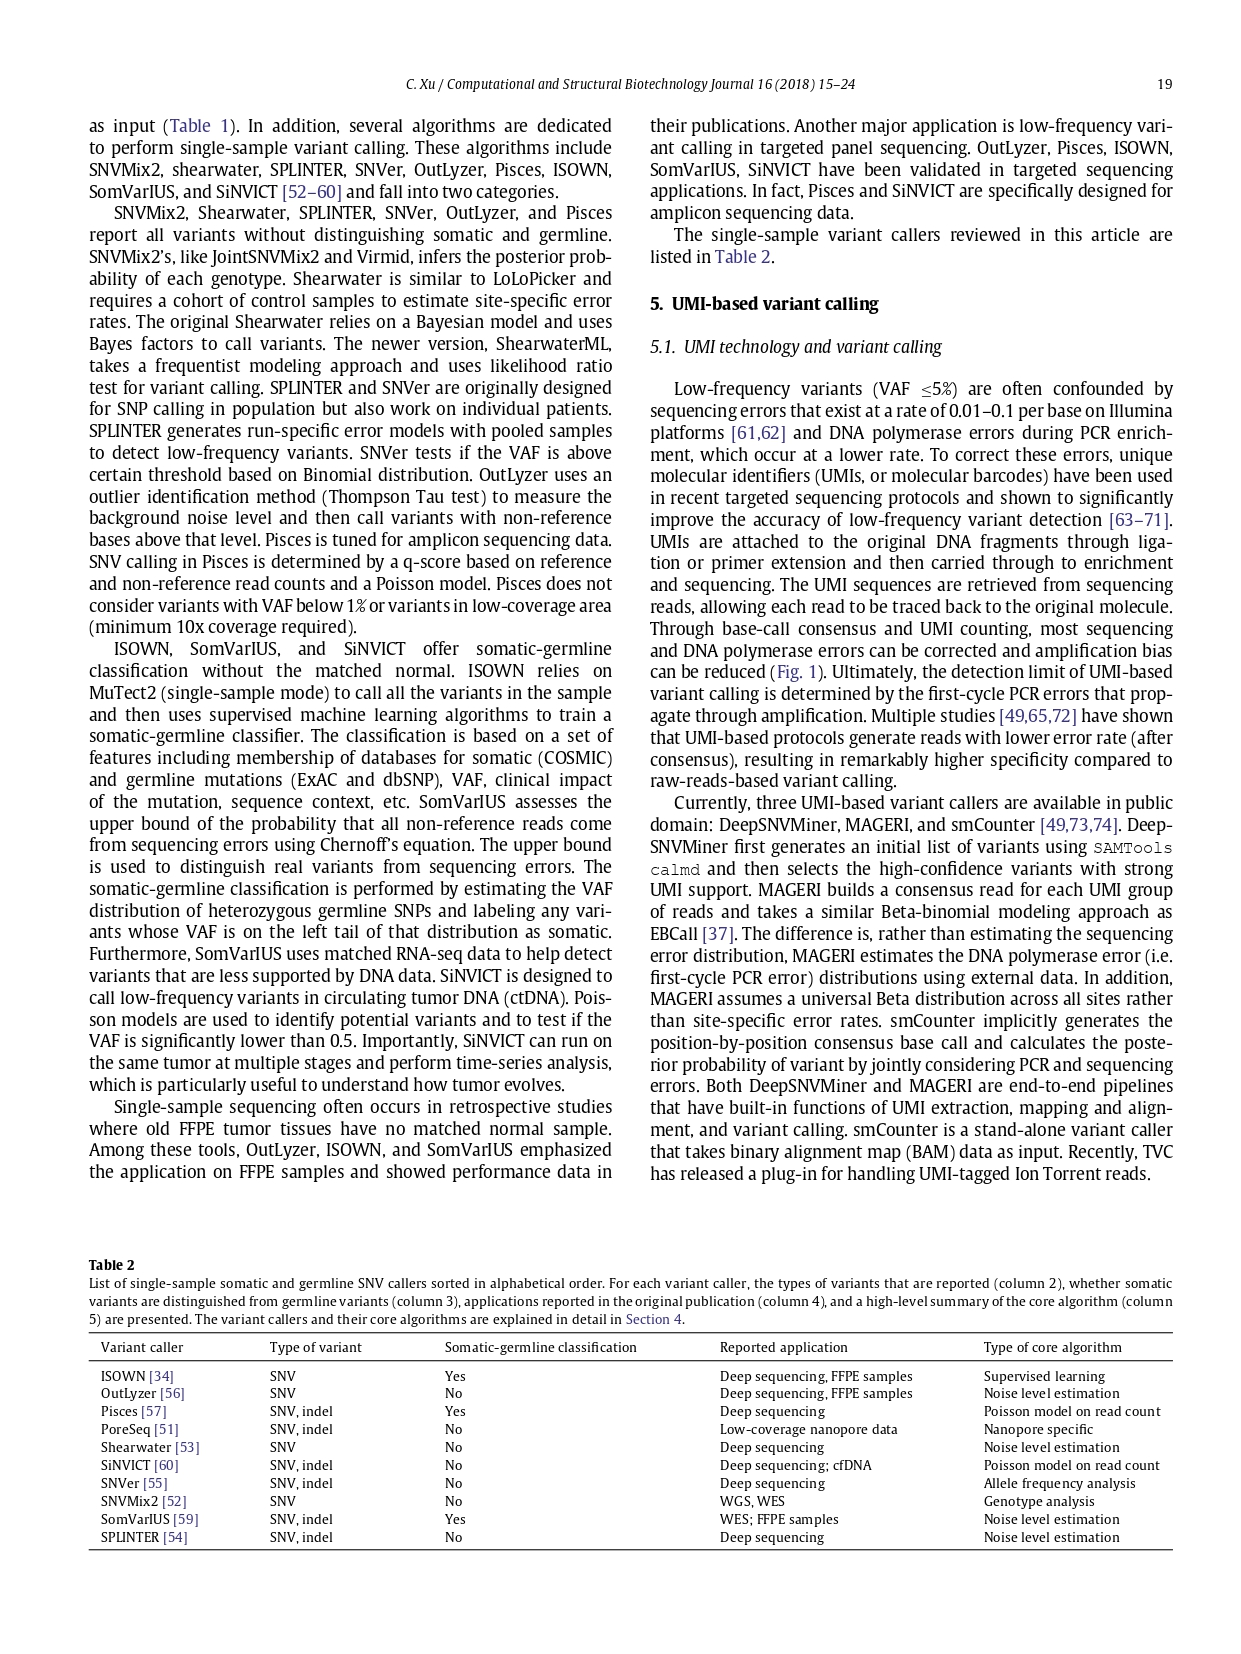


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/images/pubmed/823__3.jpg
    Resolution: 150 dpi
    Width: 1257 px
    Height: 1632 px
    Mode: 5
    Number of channels: 3


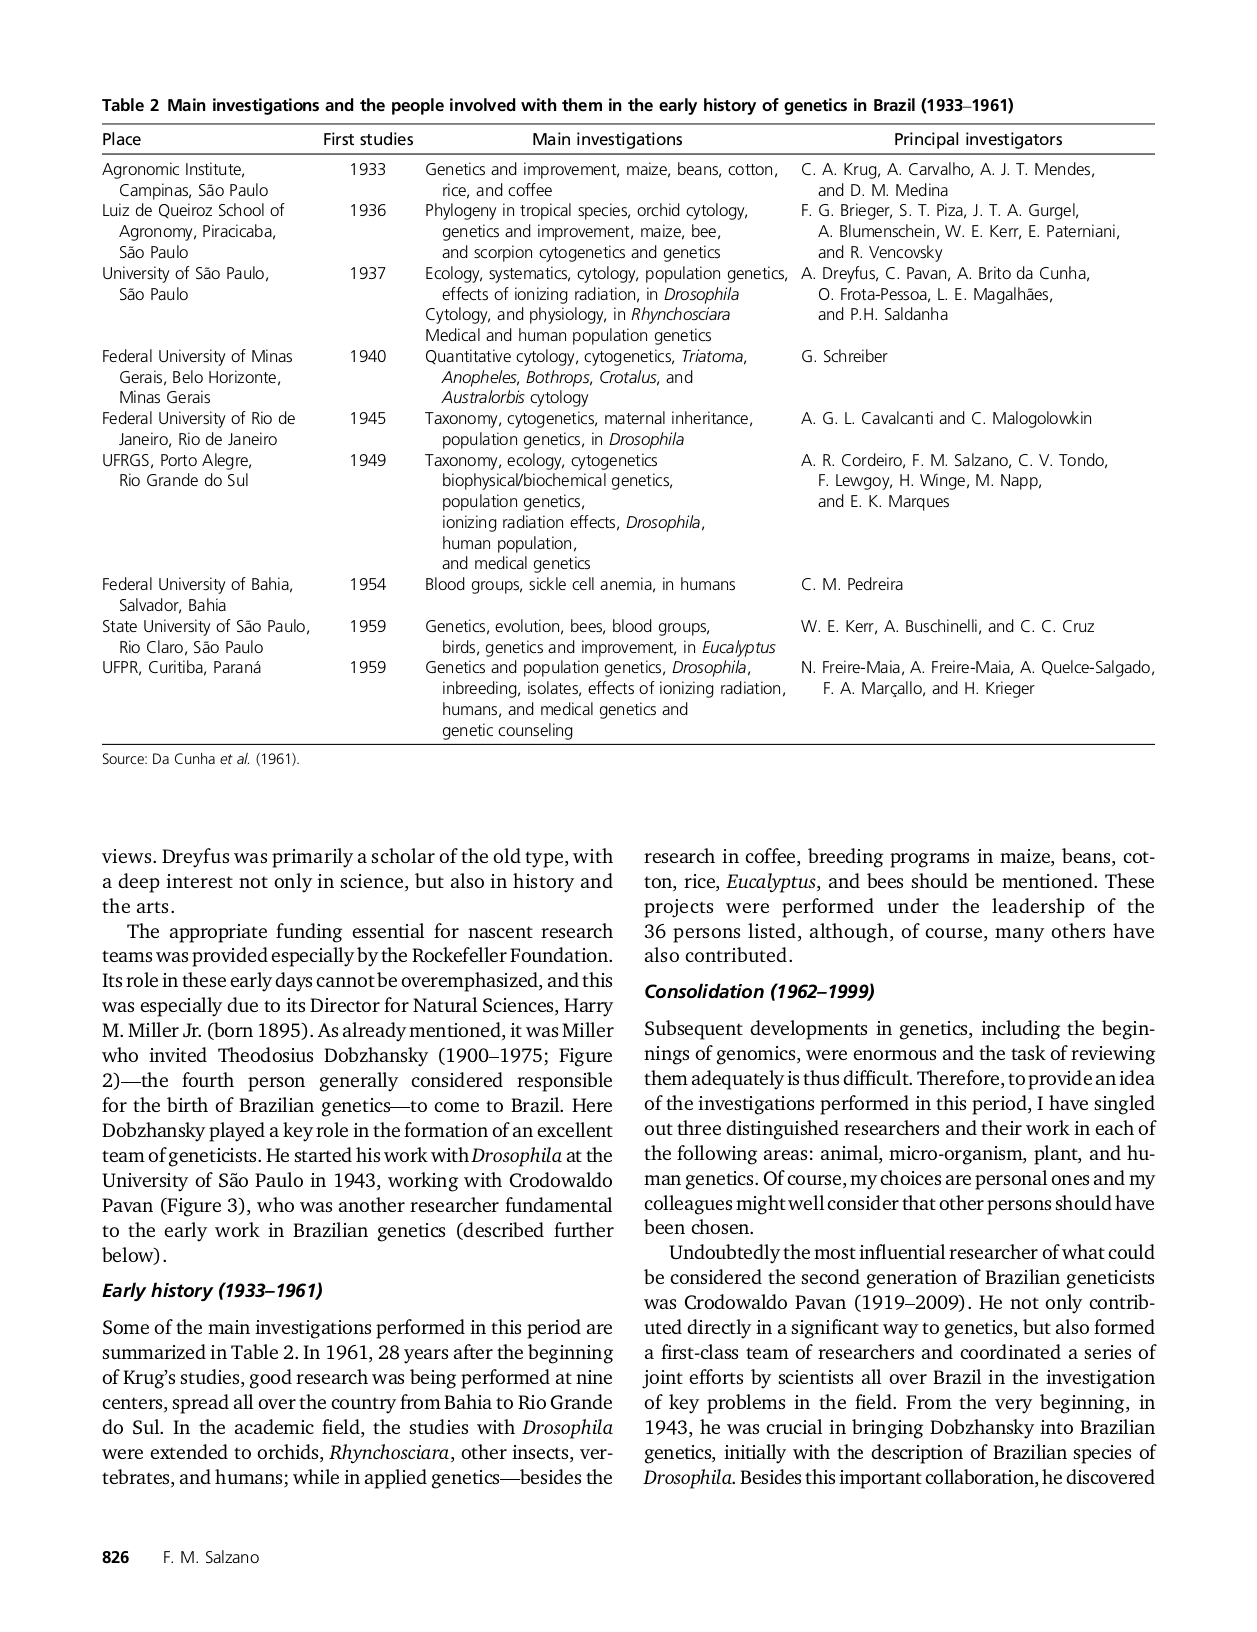

In [5]:
display_images(df)

In [11]:
proc = VisualDocumentProcessor() \
    .setInputCol("image") \
    .setOutputCols(["text", "tables"]) \
    .setFreeTextOnly(True) \
    .setOcrEngine(VisualDocumentProcessorOcrEngines.EASYOCR)

result = proc.transform(df.repartition(1)).cache()
result.show()

16:27:44, INFO Run visual document processor                        (0 + 1) / 1]
16:28:46, INFO detected formats: [<InputFormat.IMAGE: 'image'>]     (0 + 1) / 1]
16:28:46, INFO Going to convert document batch...
16:28:46, INFO Initializing pipeline for StandardPdfPipeline with options hash 421ba4e4843830933a802ab37ebecbc9
16:28:47, INFO Loading plugin 'docling_defaults'
16:28:47, INFO Registered picture descriptions: ['vlm', 'api']
16:28:48, INFO Loading plugin 'docling_defaults'
16:28:48, INFO Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
16:28:48, INFO Accelerator device: 'cuda:0'
16:28:49, INFO Accelerator device: 'cuda:0'
16:28:50, INFO Accelerator device: 'cuda:0'
16:28:51, INFO Processing document tmp
16:28:59, INFO Finished converting document tmp in 12.59 sec.
16:28:59, WARNING Parameter `strict_text` has been deprecated and will be ignored.
16:28:59, WARNING Usage of TableItem.export_to_dataframe() without `doc` argument is depreca

+--------------------+--------------------+--------------------+-------+-------+--------------------+--------------------+---------+
|               image|                path|    modificationTime| length|pagenum|                text|              tables|exception|
+--------------------+--------------------+--------------------+-------+-------+--------------------+--------------------+---------+
|{file:/home/jose/...|file:/home/jose/s...|2025-09-19 11:22:...|1438004|      0|[45 to perform si...|[{NULL, [[{ISOWN ...|     NULL|
|{file:/home/jose/...|file:/home/jose/s...|2025-09-19 11:22:...|1043573|      0|[Table 2 Main inv...|[{NULL, [[{Agrono...|     NULL|
+--------------------+--------------------+--------------------+-------+-------+--------------------+--------------------+---------+



### Inspecting the Text

In [12]:
for _, v in result.select("text").toPandas().iterrows():
  for txt in v["text"]:
      print(txt)

45 to perform single-sample variant calling: These algorithms include SomVarIUS, and SiNVICT [52-60] and fall into two categories.

ISOWN, SomVarIUS , and SiNVICT offer somatic-germline classification without   the matched norMal ISOWN relies MuTect2 (single-sample mode) to call all the variants in the sample and then uses supervised machine learning algorithms to train somatic-germline classifier. The classification is based on d set of features including membership of databases for somatic (COSMIC) and germline mutations (ExAC and dbSNP) VAF, clinical impact upper bound of the probability that all non-reference reads come from sequencing errors using Chernoff's equation. The upper bound The somatic-germline classification is performed by estimating the VAF distribution of heterozygous germline SNPs and labeling any variants whose VAF is on the left tail of that distribution as somatic. Furthermore, SomVarIUS uses matched RNA-seq data to help detect variants that are less supported by

In [13]:
from pyspark.sql.functions import explode, col, monotonically_increasing_id
result = result.withColumn("table", explode(col("tables"))).withColumn("id", monotonically_increasing_id())
display_tables(result, table_col = "table", table_index_col = "id", empty_val = "")

Filename: main_1__4.jpg
Page: 0
Table: 0
Number of Columns: 5


Filename: 823__3.jpg
Page: 0
Table: 1
Number of Columns: 4


# PDF input file

In [18]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables
from pyspark.ml import PipelineModel

pdfPath = "./data/pdfs/genetic_report.pdf"

df = spark.read.format("binaryFile").load(pdfPath)

proc = VisualDocumentProcessor() \
    .setInputCol("content") \
    .setOutputCols(["text", "tables"]) \
    .setFreeTextOnly(True) \
    .setOutputFormat(OcrOutputFormat.JSON) \
    .setOcrEngine(VisualDocumentProcessorOcrEngines.EASYOCR)
    
result = proc.transform(df).cache()
result.show()

16:46:46, INFO Run visual document processor                        (0 + 1) / 1]
16:47:47, INFO detected formats: [<InputFormat.PDF: 'pdf'>]         (0 + 1) / 1]
16:47:47, INFO Going to convert document batch...
16:47:47, INFO Initializing pipeline for StandardPdfPipeline with options hash 5b09ff02af454e2888e75c1cd4aaacd0
16:47:48, INFO Loading plugin 'docling_defaults'
16:47:48, INFO Registered picture descriptions: ['vlm', 'api']
16:47:48, INFO Loading plugin 'docling_defaults'
16:47:48, INFO Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
16:47:48, INFO rapidocr cannot be used because onnxruntime is not installed.
16:47:49, INFO Accelerator device: 'cuda:0'
16:47:50, INFO Auto OCR model selected easyocr.
16:47:50, INFO Accelerator device: 'cuda:0'
16:47:51, INFO Accelerator device: 'cuda:0'
16:47:52, INFO Processing document tmp
16:47:54, INFO Finished converting document tmp in 6.58 sec.
16:47:54, WARNING Usage of TableItem.export_to_data

+--------------------+--------------------+------+--------------------+--------------------+--------------------+---------+
|                path|    modificationTime|length|             content|                text|              tables|exception|
+--------------------+--------------------+------+--------------------+--------------------+--------------------+---------+
|file:/home/jose/s...|2025-05-31 12:49:...|461438|[25 50 44 46 2D 3...|[{"schema_name": ...|[{NULL, [[{Non-sm...|         |
+--------------------+--------------------+------+--------------------+--------------------+--------------------+---------+




    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/pdfs/genetic_report.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


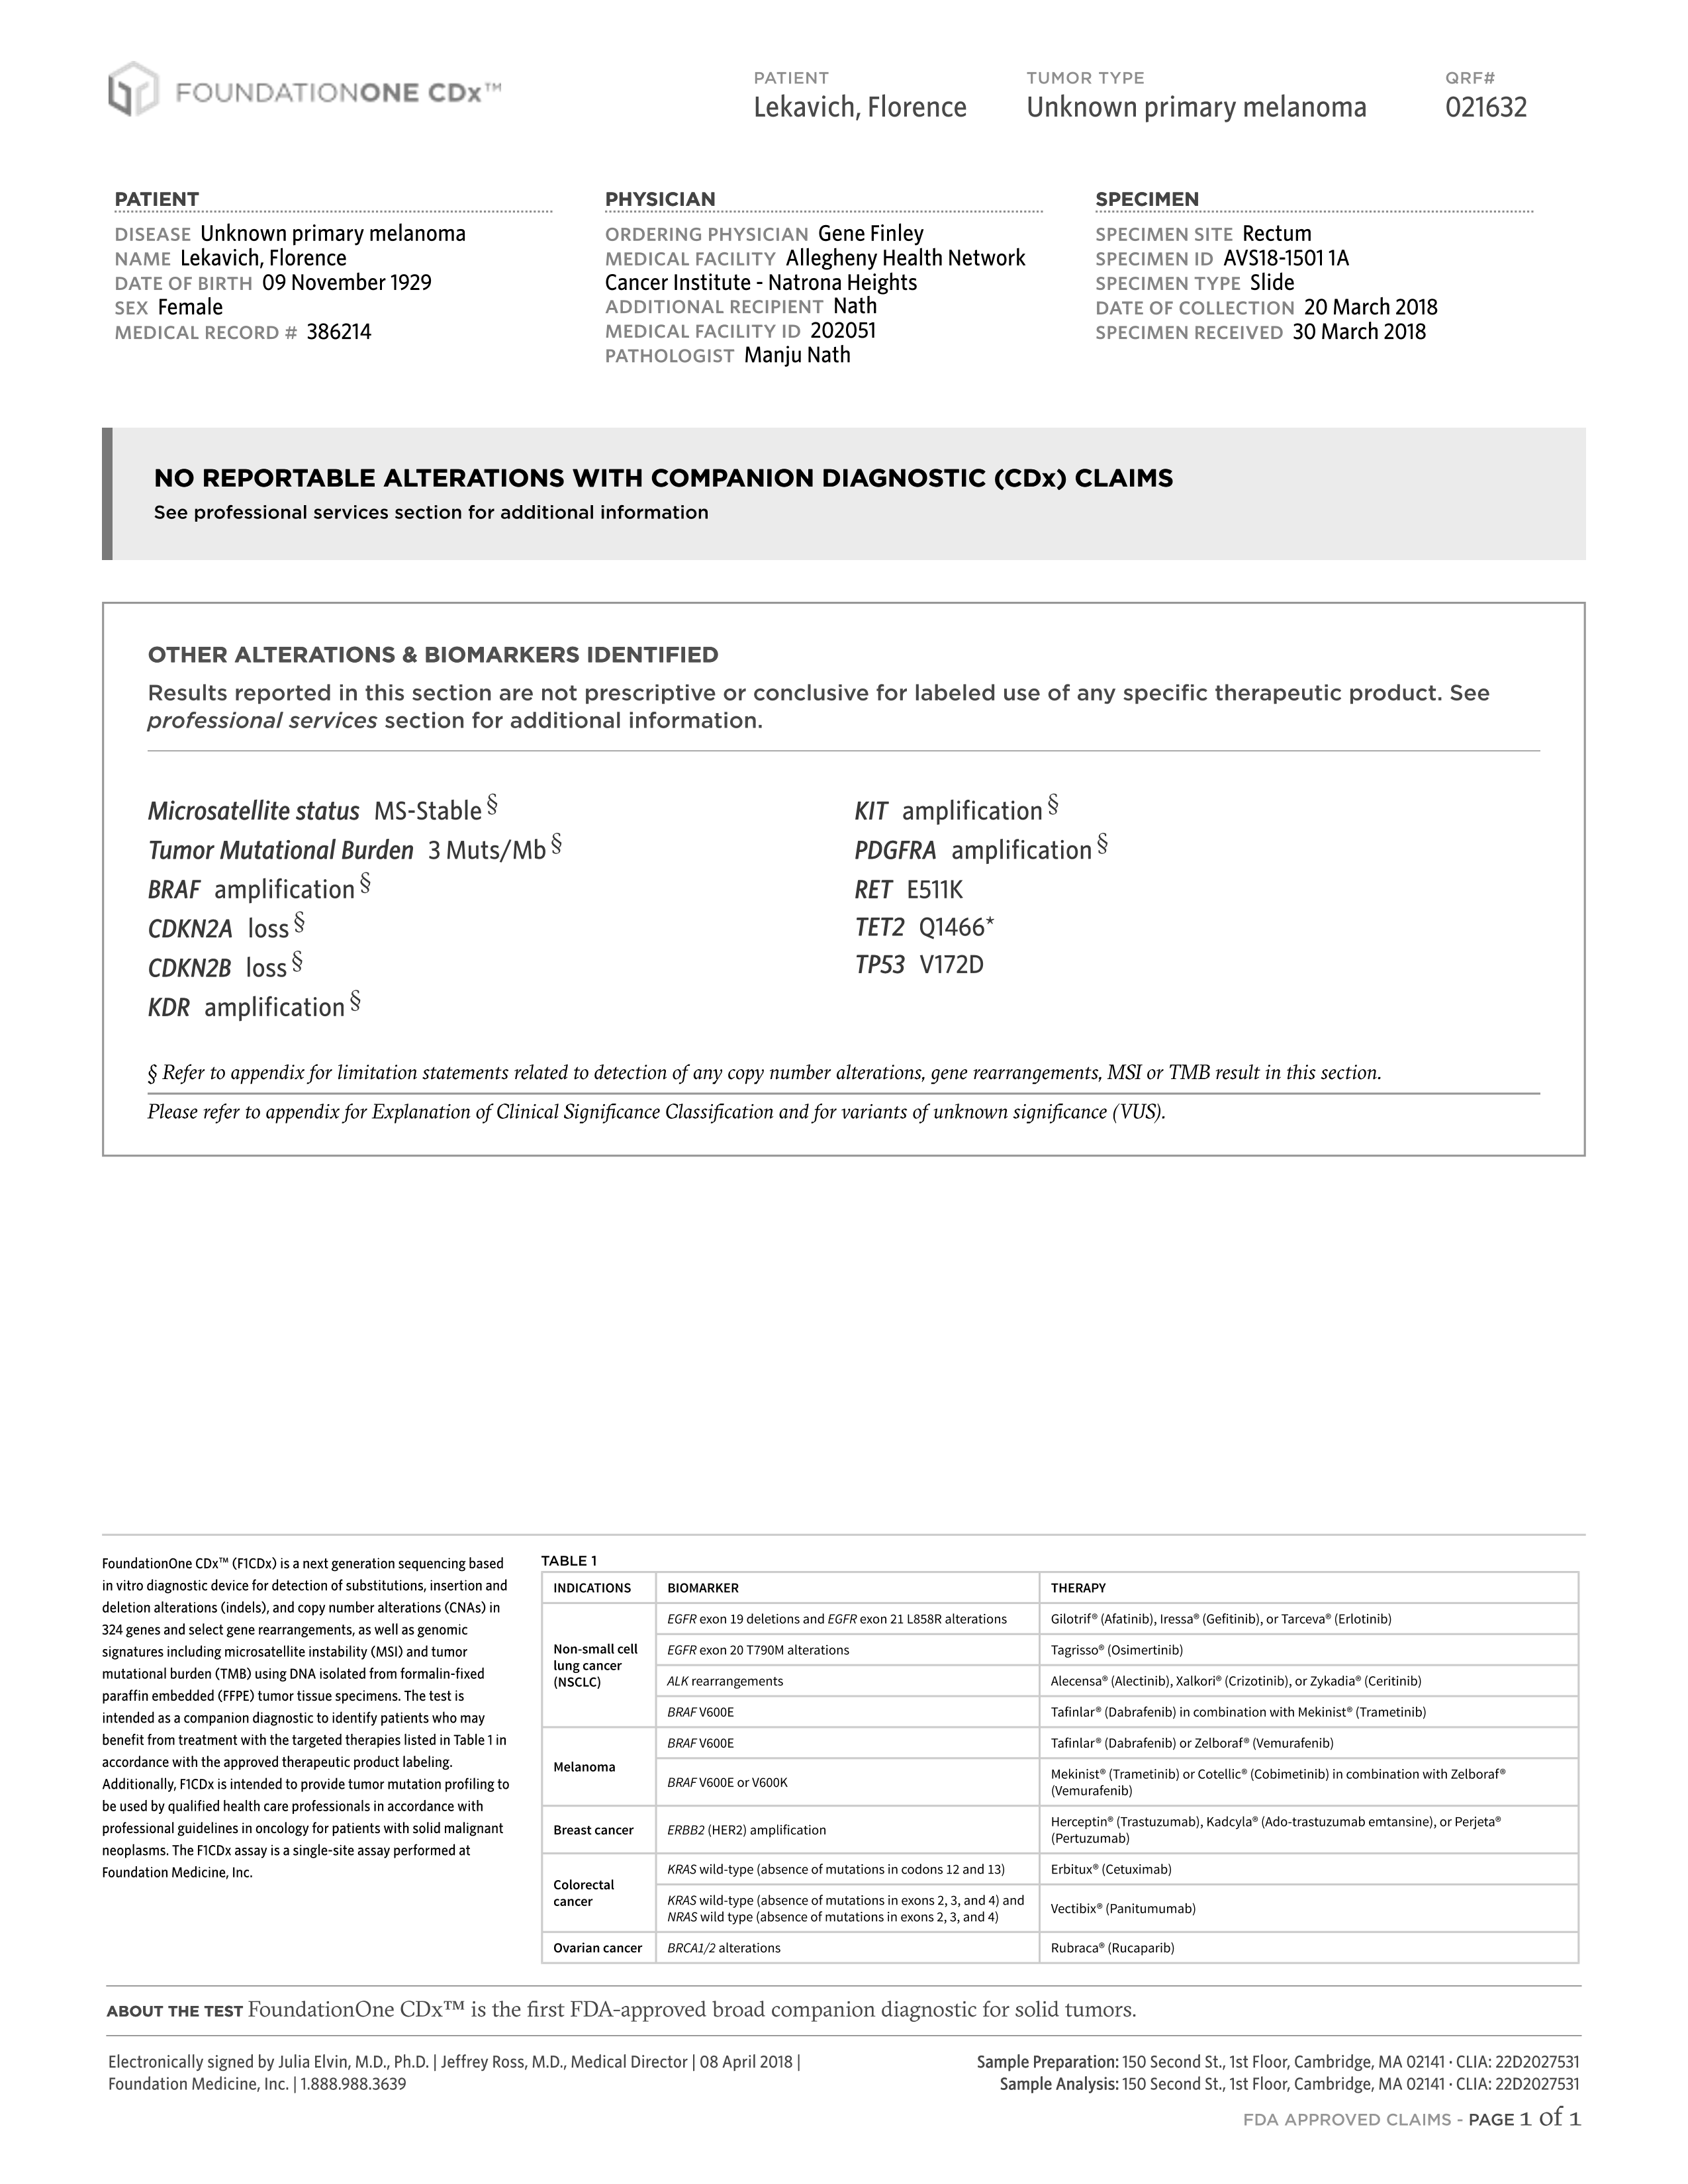


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/pdfs/genetic_report.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


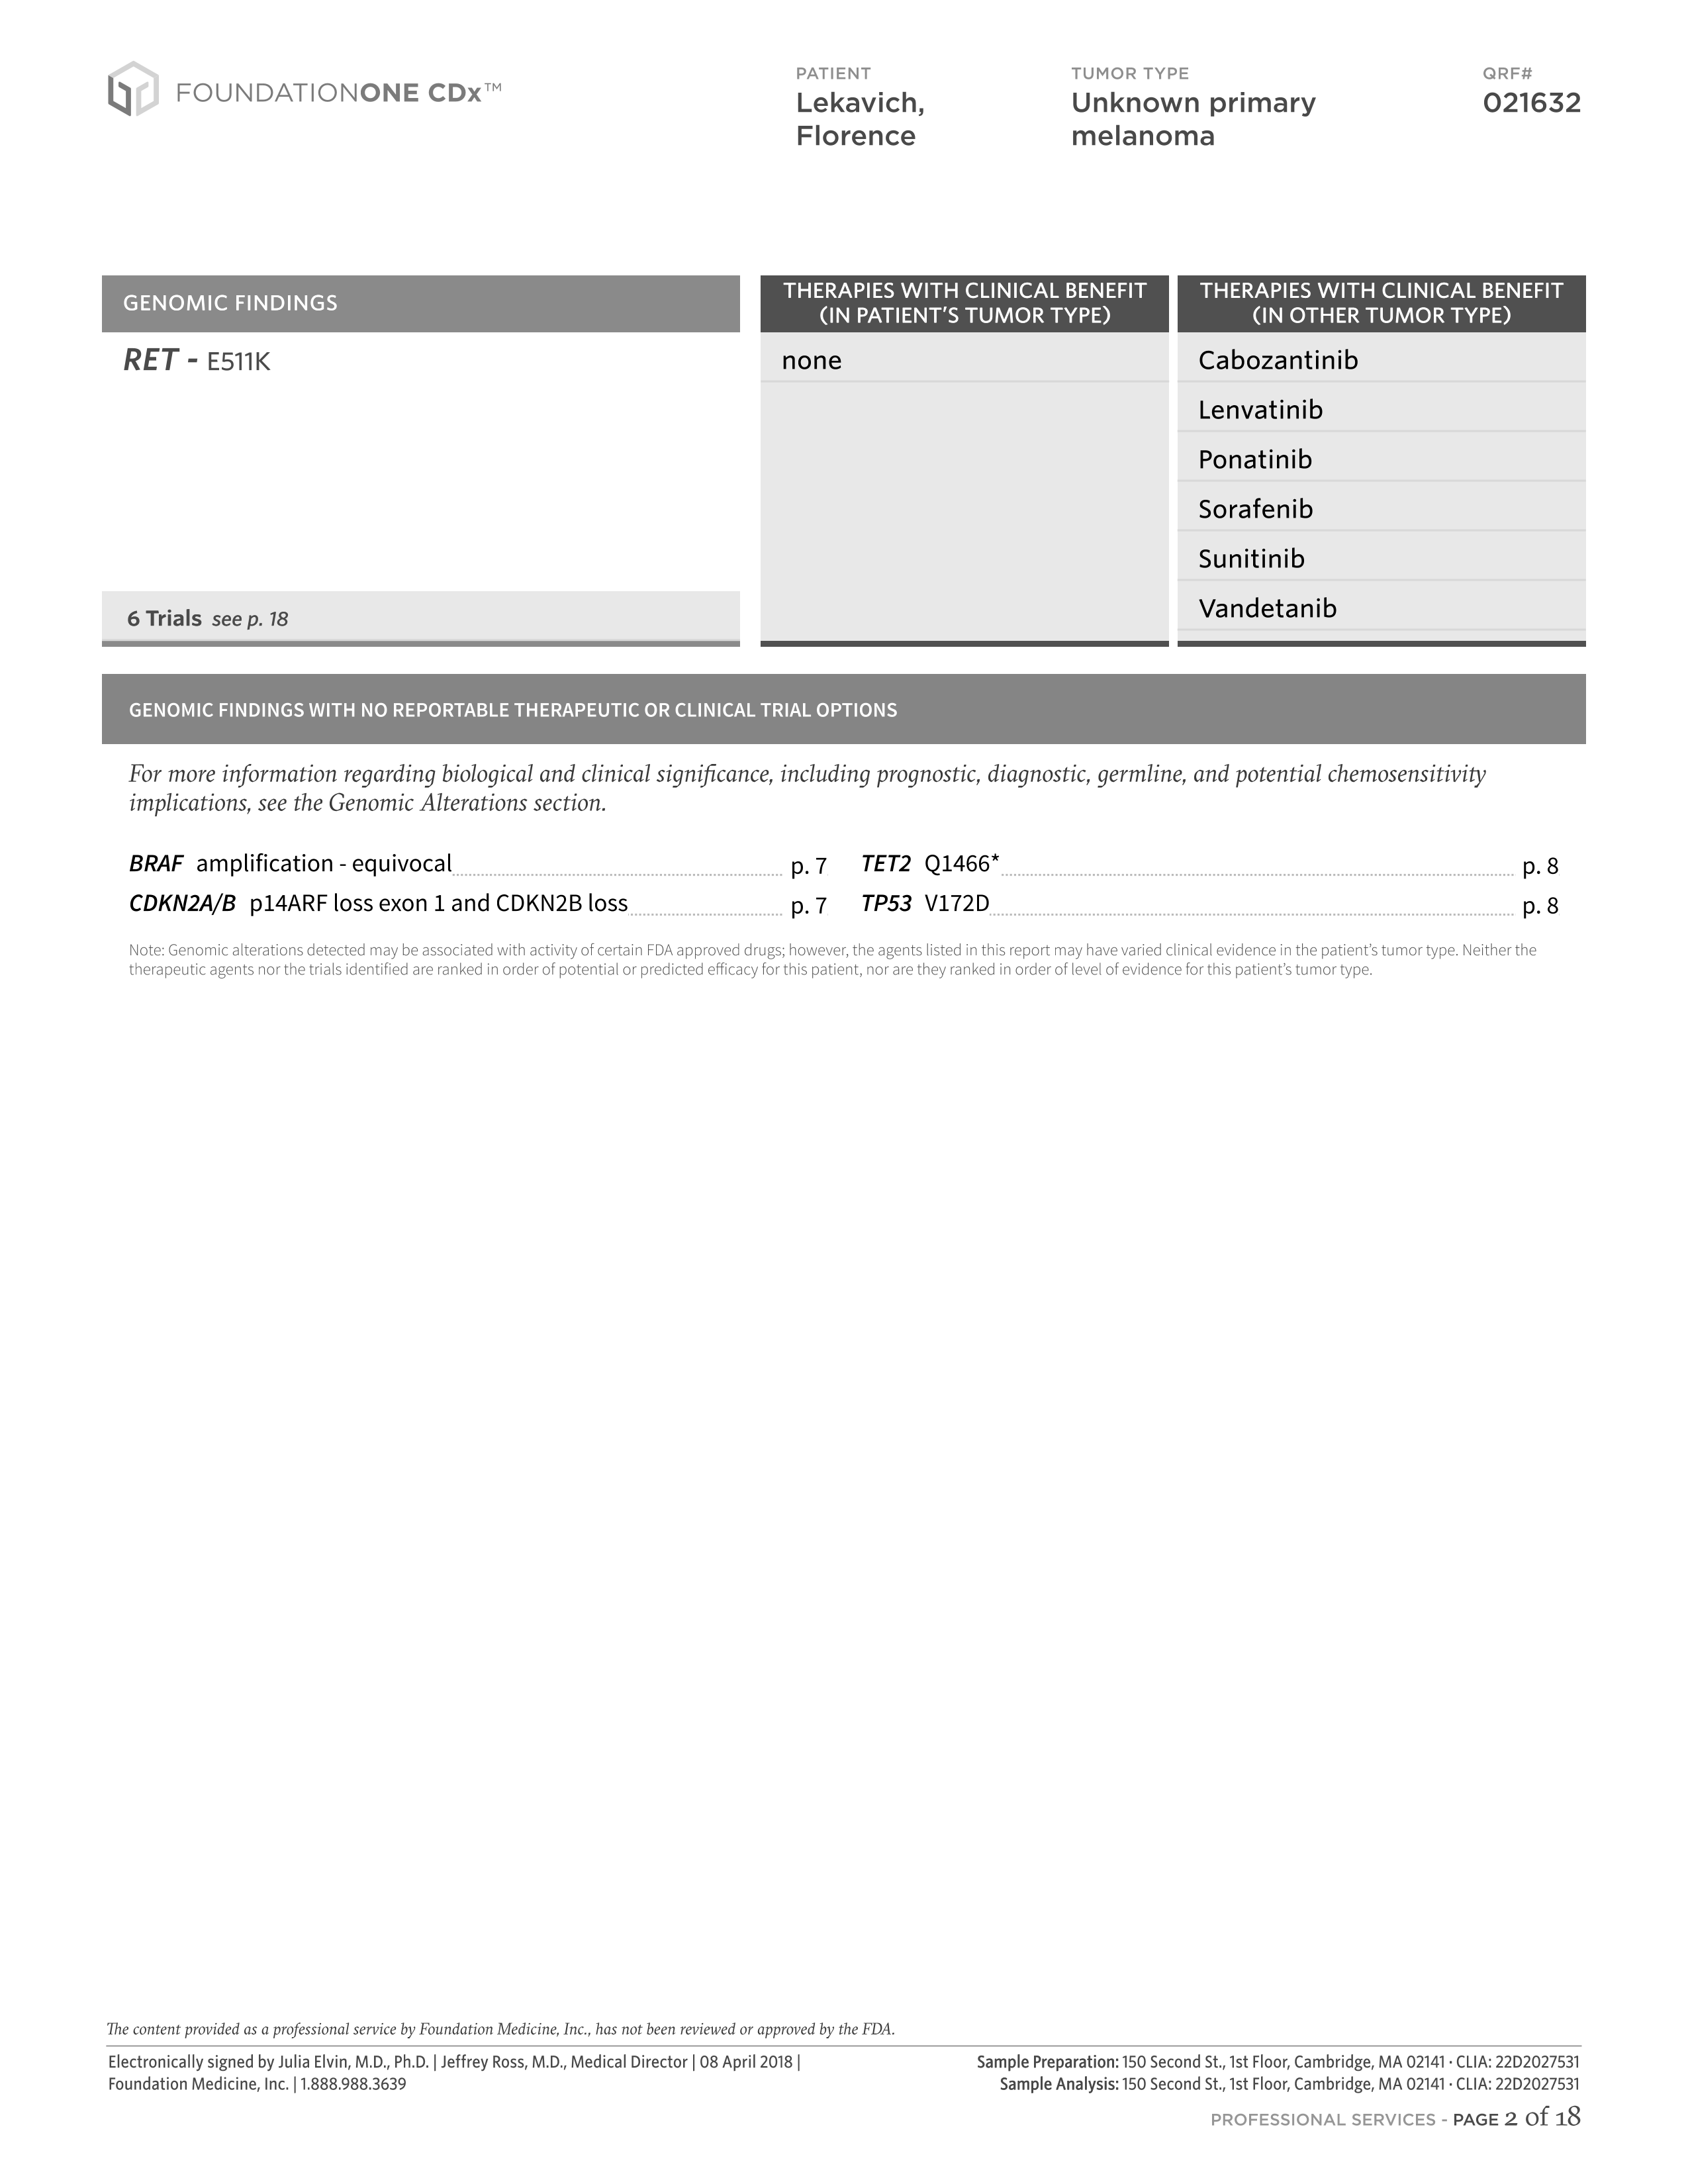


    Image #2:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/pdfs/genetic_report.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


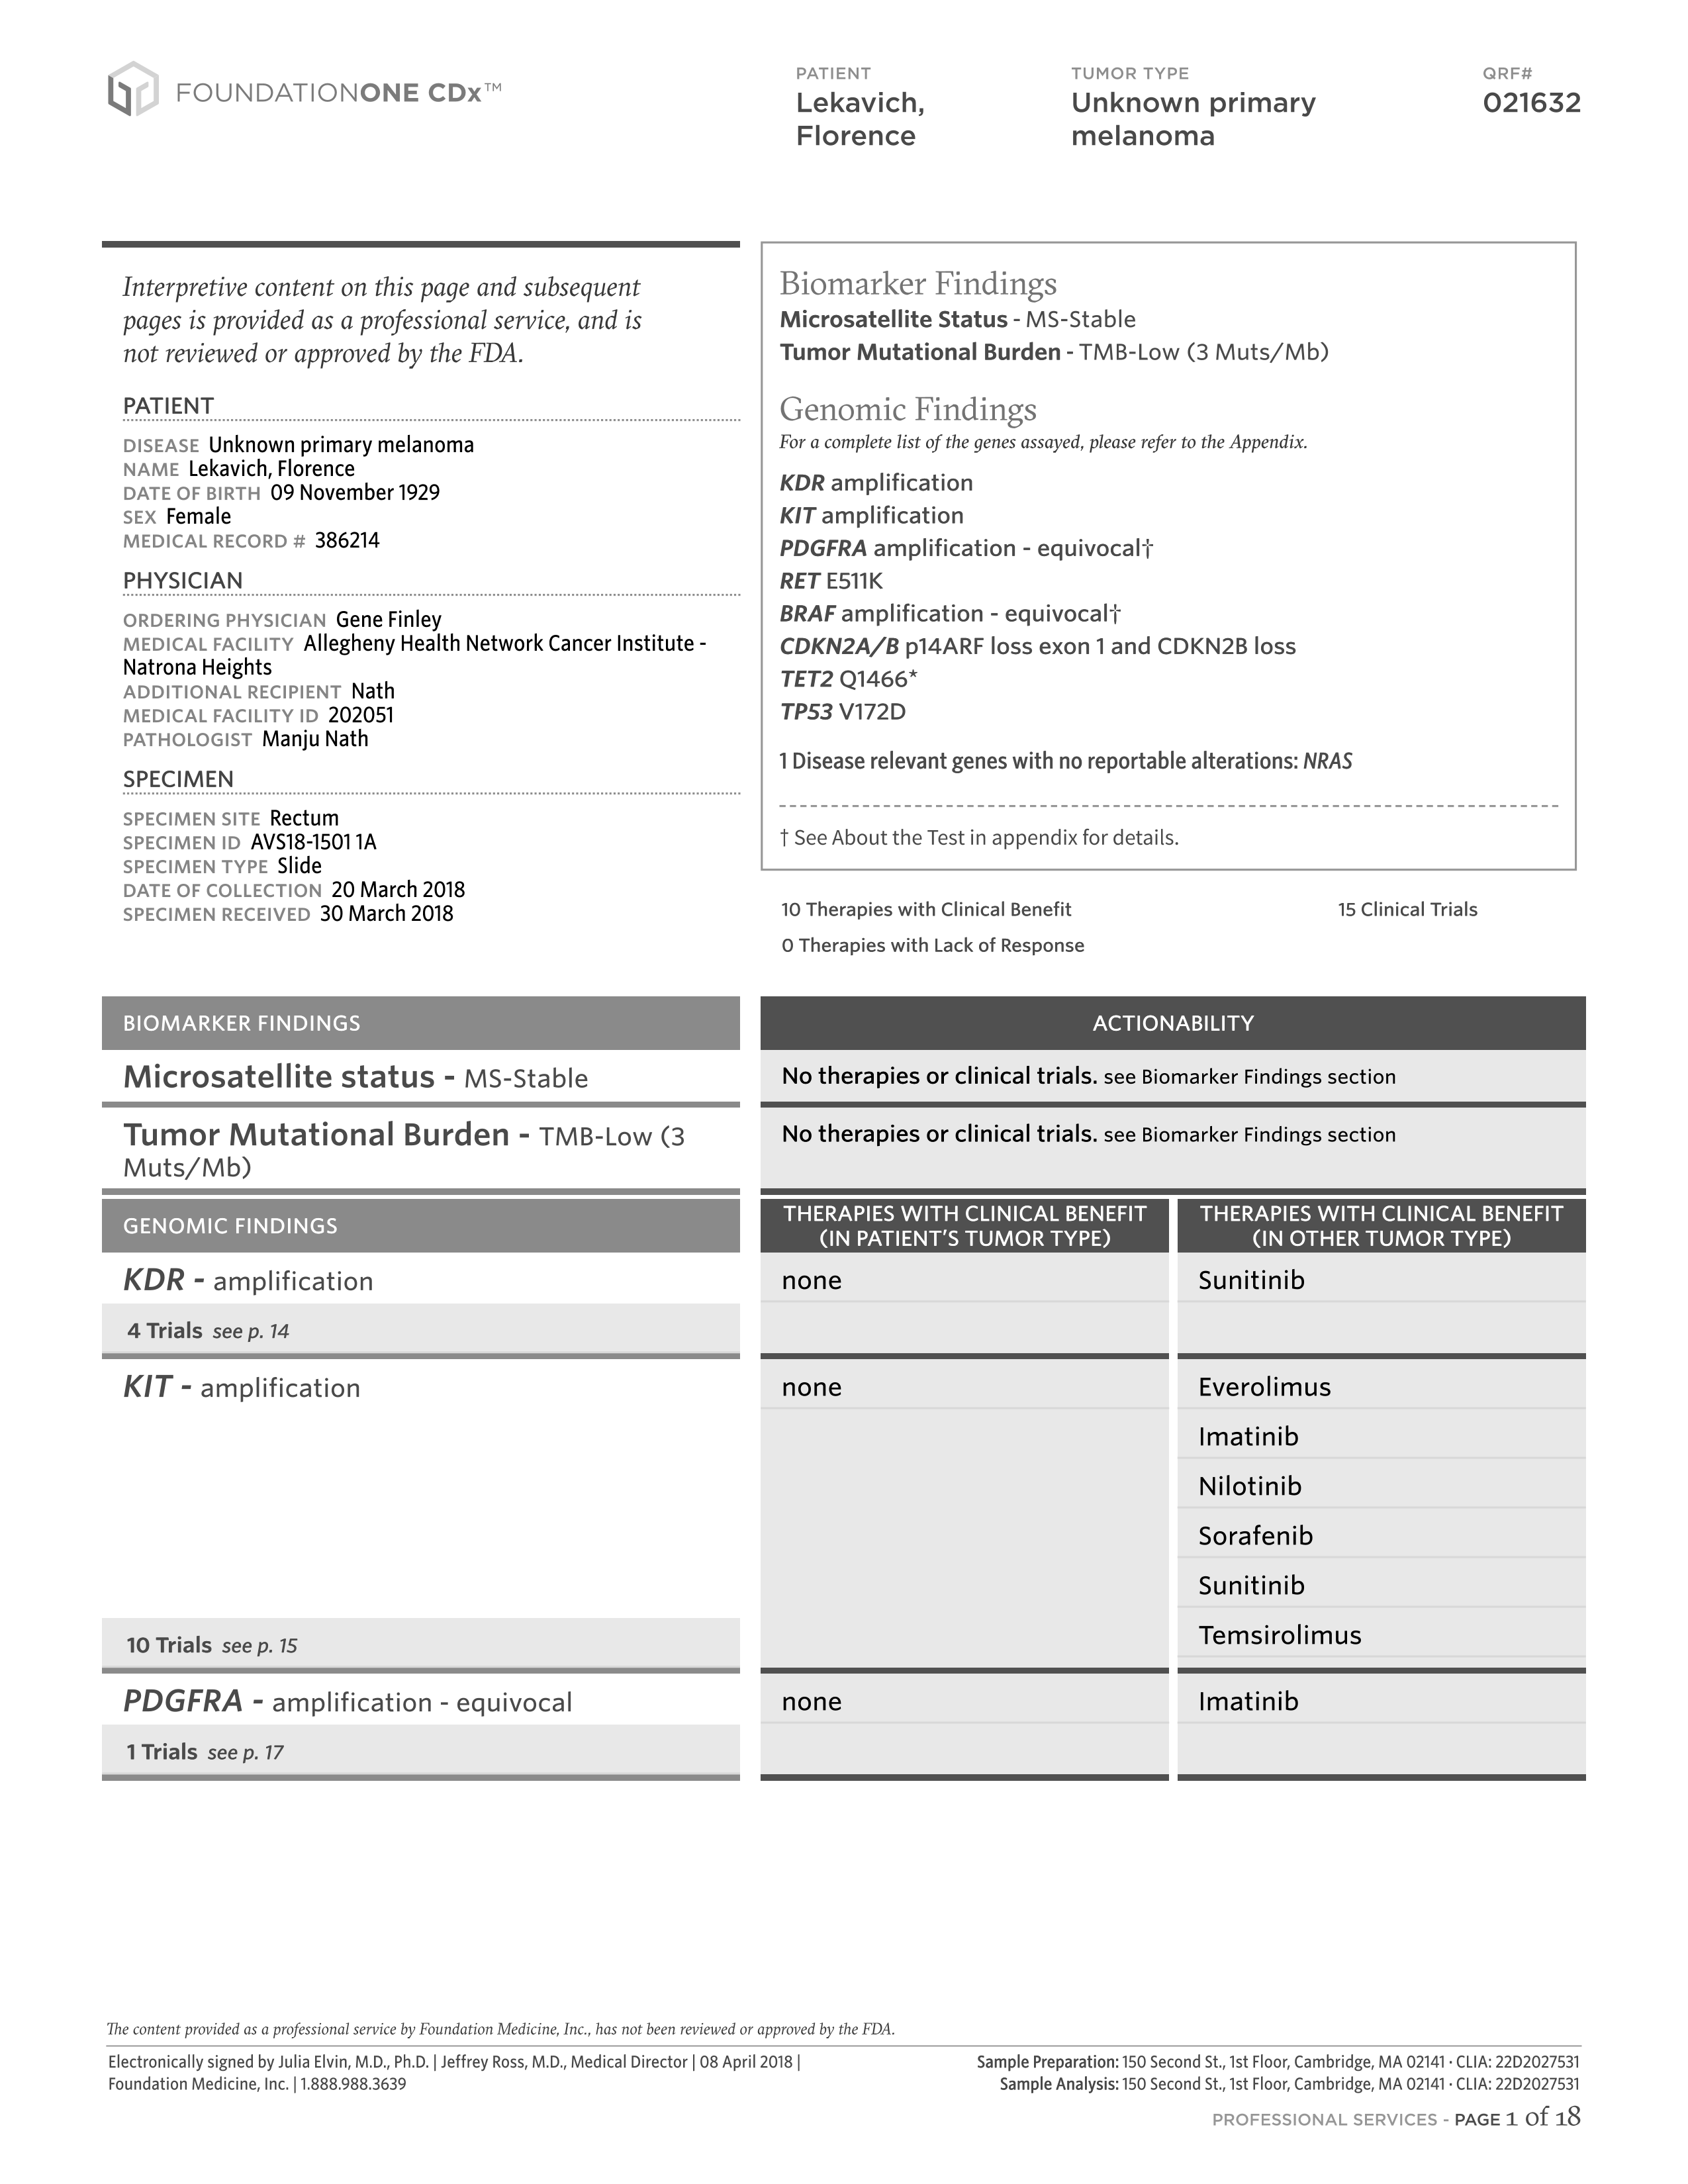

In [16]:
from sparkocr.utils import display_pdf

display_pdf(df)

# Output format JSON

In [20]:
import json
for _, v in result.select("text").toPandas().iterrows():
  for txt in v["text"]:
      parsed = json.loads(txt)
      print(json.dumps(parsed, indent=4))

{
    "schema_name": "DoclingDocument",
    "version": "1.7.0",
    "name": "tmp",
    "origin": {
        "mimetype": "application/pdf",
        "binary_hash": 3052283336876577105,
        "filename": "tmp"
    },
    "furniture": {
        "self_ref": "#/furniture",
        "children": [],
        "content_layer": "furniture",
        "name": "_root_",
        "label": "unspecified"
    },
    "body": {
        "self_ref": "#/body",
        "children": [
            {
                "$ref": "#/texts/0"
            },
            {
                "$ref": "#/texts/1"
            },
            {
                "$ref": "#/texts/2"
            },
            {
                "$ref": "#/texts/3"
            },
            {
                "$ref": "#/pictures/0"
            },
            {
                "$ref": "#/texts/4"
            },
            {
                "$ref": "#/groups/0"
            },
            {
                "$ref": "#/texts/15"
            },
            {


# PPTX case

In [6]:
pptxPath = "./data/ppt/*.pptx"

df = spark.read.format("binaryFile").load(pptxPath)

proc = VisualDocumentProcessor() \
    .setInputCol("content") \
    .setOutputCols(["text", "tables"]) \
    .setOcrEngine(VisualDocumentProcessorOcrEngines.EASYOCR)

result = proc.transform(df).cache()

for _, v in result.select("text").toPandas().iterrows():
  for txt in v["text"]:
      print(txt)

17:56:47, INFO Run visual document processor                        (0 + 1) / 1]
17:57:49, INFO detected formats: [<InputFormat.PPTX: 'pptx'>]       (0 + 1) / 1]
17:57:49, INFO Going to convert document batch...
17:57:49, INFO Initializing pipeline for SimplePipeline with options hash 540f870d50363a349facee04dbb33957
17:57:50, INFO Loading plugin 'docling_defaults'
17:57:50, INFO Registered picture descriptions: ['vlm', 'api']
17:57:50, INFO Processing document tmp
17:57:50, WARNING Warning: image cannot be loaded by Pillow: cannot find loader for this WMF file
17:57:50, WARNING Warning: image cannot be loaded by Pillow: cannot find loader for this WMF file
17:57:50, WARNING Warning: image cannot be loaded by Pillow: cannot find loader for this WMF file
17:57:50, WARNING Warning: image cannot be loaded by Pillow: cannot find loader for this WMF file
17:57:50, INFO Finished converting document tmp in 0.98 sec.


# A Maintenance Program for a bus fleet

Lessons from a Potential CDM Project in India

Kaushik Deb, TERI
26 August 2004

Transport CDM Workshop

# Structure of the presentation

The policy context

CDM and transport: Synergies 

Key barriers

The Project

- Need for an effective maintenance
- Inspection Systems: CDM project
- Emission savings
- Cost estimates

Lessons
# Urban transport in India

Large urban population

- Over 1/3 in 2001
- 33% concentrated in cities with 10% population
- 82% are personal vehicles
- Effective public transport in only 10 cities
- Rail in only 3 cities
- Cities are vertices of continued growth

High vehicle density in urban areas

Inadequate public transport

No urban transport  policy

Diffused institutional arrangements

Implications for economic sustainability
26 August 2004

Transport CDM Workshop

# Trends in vehicle population
26 August 2004

Transport CDM Workshop

# Vehicle Ownership

Per capita 

income (US $) 

Cities

Vehicles Per 

1000 Perso